<a href="https://colab.research.google.com/github/EliasEconomou/AI2-Natural-Language-Processing/blob/main/Natural_Language_Processing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Datafile**

In [1]:
import numpy as np
import pandas as pd

import sys
import os.path

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer


from itertools import chain
from wordcloud import WordCloud

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
# Read data files
def read_csv_file(filePath,separator):
  fileExists = os.path.exists(filePath)
  if fileExists:
    rFile = pd.read_csv(filePath,sep=separator)
  else:
    print('Enter data file path:')
    filePath = input()
    rFile = pd.read_csv(filePath,sep=separator)
  return rFile

In [3]:
# Reading data file
filePath = "./drive/MyDrive/ColabNotebooks/Homework_1/imdb-reviews.csv"
initDF = read_csv_file(filePath,'\t')
initDF.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


# **Preprocessing and Cleaning Data**
> We start by cleaning the given dataset of missing values, stop words, links, emojis etc and tokenizing the data.

In [4]:
toBeCleanDF = initDF

# Let's remove any missing values
toBeCleanDF.dropna(inplace = True)

# We 're probably going to skip using the url column
toBeCleanDF = toBeCleanDF.drop(["url"], axis=1)

# Change the column order for simplicity
toBeCleanDF = toBeCleanDF[["review","rating"]]

initDFrows = initDF.shape[0]

In [5]:
print(initDF.iloc[45003][2])

I don't even know where to begin...<br /><br />It's is not worth typing a review so I will just quote what another user posted because I agree thoroughly, but I give it 1 / 10 instead of 2 / 10 "I am at a loss to find the words to express how bad I thought this film was. The initial precept was promising, but in all respects afterwards it was totally awful. Let's run through the main points. Plot - good initial idea but truly terrible development. There were many points when I thought "no, nobody would do something that stupid". The ending was amazingly anticlimactic. Characterisation - all of the characters were either completely bland or grotesque caricatures. I keep trying to think of one that wasn't - possibly the mother, but that's it. Music - intrusive, inappropriate and generally terrible. Direction - totally amateurish. Cinematography - doubt they've heard of it. Camera angles / stability / zoom levels often really bad. I am totally bemused at how this film has scored so highly

In [6]:
# Remove punctuation, links, hashtags, new lines etc, using regular expressions
toBeCleanDF["review"] = toBeCleanDF["review"].replace('\"|\'|\.|,|\?|!|:|\(|\)|%|\$|;','', regex=True)
toBeCleanDF["review"] = toBeCleanDF["review"].replace('\n|\t','', regex=True)
toBeCleanDF["review"] = toBeCleanDF["review"].replace(r'(http\S+)|(www\S+)|(#\S+)|(&\S+)|(@\S+)','', regex=True)
toBeCleanDF["review"] = toBeCleanDF["review"].replace('(\s-\s)','', regex=True)
toBeCleanDF["review"] = toBeCleanDF["review"].replace(r'\b[0-9]+\b', '', regex=True)
toBeCleanDF["review"] = toBeCleanDF["review"].replace("<br />", ' ', regex=True)
toBeCleanDF["review"] = toBeCleanDF["review"].replace('/','', regex=True)

# Remove emojis by encoding - decoding into ascii, resulting in ignoring them
toBeCleanDF["review"] = toBeCleanDF["review"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

# Convert review to lowercase
toBeCleanDF["review"] = toBeCleanDF["review"].str.lower()



In [7]:
print(toBeCleanDF.iloc[0][0])

i thought this was a quiet good movie it was fun to watch it what i liked best where the outtakes at the end of the movie they were great


In [8]:
# We'll create a list of stopwords to remove, like 'i','is','you', etc
stopWords = list(stopwords.words('english'))
stopWords.remove("why")
stopWords.remove("how")
stopWords.remove("against")
stopWords.remove("again")
stopWords.remove("not")
stopWords.append("'ve")
stopWords.append("'re")
stopWords.append("'s")
stopWords.append("``"),
stopWords.append("''")

In [9]:
# Now tokenize the reviews
tokenisedDF = toBeCleanDF

tokenisedDF["review"] = tokenisedDF["review"].apply(word_tokenize)
tokenisedDF["review"] = tokenisedDF["review"].apply(lambda words: [word for word in words if word not in stopWords])

# Remove any unnecessary spaces that came up
tokenisedDF["review"] = tokenisedDF["review"].replace(' +', ' ', regex=True)


In [10]:
# Let's also create a new column named evaluation to categorize reviews into positive, negative
# based on their rating (1-4 : negative as 'NEG' - 7-10 : positive as 'POS')

rating_ranges = [ (tokenisedDF["rating"] <= 4), (tokenisedDF["rating"] >=7) ]
sentiment = ["NEG", "POS"]

tokenisedDF['sentiment'] = np.select(rating_ranges, sentiment)
tokenisedDF.head()


,review,rating,sentiment
0,"[thought, quiet, good, movie, fun, watch, like...",10.0,POS
1,"[wagon, master, unique, film, amongst, john, f...",9.0,POS
2,"[film, near, perfect, film, john, ford, made, ...",10.0,POS
3,"[gave, stars, lot, interesting, themes, many, ...",4.0,NEG
4,"[movie, really, genuine, random, really, hard,...",10.0,POS


In [11]:
# Lemmatization

lemmatizer = WordNetLemmatizer()

In [30]:
def lemmatize(words):
# WordNetLemmatizer().lemmatize(word,'v'),WordNetLemmatizer().lemmatize(word,'n')
     words = [lemmatizer.lemmatize(noun, "n") for noun in words]
     words = [lemmatizer.lemmatize(verb, "v") for verb in words]
     return words

lemmatisedDF = tokenisedDF.assign(review = tokenisedDF.review.apply(lambda x: lemmatize(x)))

In [31]:
lemmatisedDF

,review,rating,sentiment
0,"[think, quiet, good, movie, fun, watch, like, ...",10.0,POS
1,"[wagon, master, unique, film, amongst, john, f...",9.0,POS
2,"[film, near, perfect, film, john, ford, make, ...",10.0,POS
3,"[give, star, lot, interest, theme, many, alrea...",4.0,NEG
4,"[movie, really, genuine, random, really, hard,...",10.0,POS
...,...,...,...
45003,"[dont, even, know, begin, not, worth, type, re...",1.0,NEG
45004,"[one, worst, movie, saw, 90, id, often, use, b...",1.0,NEG
45005,"[baldwin, really, stoop, low, make, movie, scr...",1.0,NEG
45006,"[like, watch, mel, gibson, million, dollar, ho...",1.0,NEG


# **Analyzing Data (optional)**


> Let's do some basic analysis to extract usefull information about our reviews.



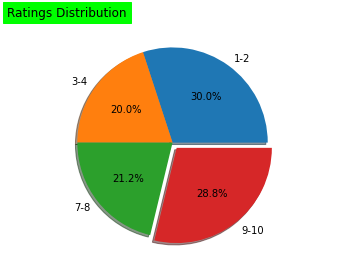

In [32]:
ratingsDICT = {'1-2' : 0, '3-4' : 0, '7-8' : 0, '9-10' : 0}
for rating in lemmatisedDF["rating"]:
  if rating == 1.0 or rating == 2.0:
    ratingsDICT["1-2"] += 1
  elif rating == 3.0 or rating == 4.0:
    ratingsDICT["3-4"] += 1
  elif rating == 7.0 or rating == 8.0:
    ratingsDICT["7-8"] += 1
  elif rating == 9.0 or rating == 10.0:
    ratingsDICT["9-10"] += 1

labels = ratingsDICT.keys()
sizes = ratingsDICT.values()
explode = [0, 0, 0, 0.07]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')
plt.title(label="Ratings Distribution",
          loc="left",
          pad='20.0',
          backgroundcolor='lime')
plt.show()

We see that there are almost equally numbered negative/positive reviews.

In [33]:
# Group by sentiment and plot wordclouds for most used words in every sentiment
groupBySent = lemmatisedDF.groupby('sentiment')

POSgroup = groupBySent.get_group('POS')
NEGgroup = groupBySent.get_group('NEG')

In [34]:
POSList = list(chain.from_iterable(list(POSgroup["review"])))
POSfdist = FreqDist(POSList)
NEGList = list(chain.from_iterable(list(NEGgroup["review"])))
NEGfdist = FreqDist(NEGList)

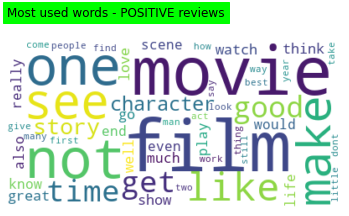

In [35]:
POScloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(POSfdist)

plt.imshow(POScloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - POSITIVE reviews',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

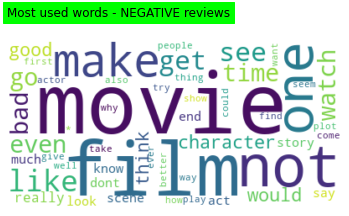

In [36]:
NEGcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(NEGfdist)

plt.imshow(NEGcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - NEGATIVE reviews',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

# **TF-IDF Vectorizer**


> Here we'll split data into train/test sets and transform our Xtrain / Xtest text into vector space models using TF-IDF.



In [37]:
DF = lemmatisedDF

# Keep data in X and labels in y
X, y = DF.drop(columns = ["sentiment","rating"]), DF.drop(columns = ["review","rating"])
print(X.shape, y.shape)

(45008, 1) (45008, 1)


In [38]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36006, 1) (9002, 1) (36006, 1) (9002, 1)


In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=500)

# Create TD-IDF for train data
tfidf_X_train = tfidf_vectorizer.fit_transform(X_train["review"].astype(str))

# Create TD-IDF for test data
tfidf_X_test = tfidf_vectorizer.transform(X_test["review"].astype(str))

In [40]:
print(tfidf_vectorizer.vocabulary_)

{'think': 432, 'good': 185, 'movie': 284, 'fun': 176, 'watch': 469, 'like': 252, 'best': 40, 'end': 127, 'great': 187, 'film': 164, 'john': 230, 'work': 483, 'one': 306, 'base': 34, 'story': 412, 'write': 490, 'director': 112, 'son': 397, 'turn': 448, 'opinion': 308, 'call': 57, 'come': 75, 'want': 465, 'say': 364, 'not': 297, 'little': 254, 'might': 275, 'expect': 145, 'find': 167, 'wonderful': 480, 'cast': 64, 'deliver': 103, 'feature': 159, 'star': 406, 'except': 144, 'actor': 4, 'small': 393, 'character': 69, 'quite': 340, 'sister': 389, 'shoot': 383, 'last': 239, 'least': 246, 'start': 407, 'two': 451, 'friend': 174, 'head': 197, 'place': 324, 'thats': 426, 'way': 470, 'beautiful': 35, 'woman': 478, 'wife': 475, 'daughter': 94, 'direction': 111, 'simply': 387, 'drive': 119, 'town': 444, 'go': 183, 'nothing': 298, 'happen': 194, 'family': 154, 'father': 157, 'three': 434, 'run': 361, 'murder': 287, 'overall': 312, 'le': 243, 'must': 289, 'see': 371, 'perfect': 317, 'make': 263, 're

In [41]:
# print(tfidf_X_train),print(X_train)

In [42]:
# Training
clf = LogisticRegression(random_state=0)
print("Training the dataset with SVM using TF-IDF...")
clf.fit(tfidf_X_train, y_train.sentiment)
print("Training Completed.")

Training the dataset with SVM using TF-IDF...
Training Completed.


In [43]:
# tfidfSVM_modelPath = "./drive/MyDrive/ColabNotebooks/tfidfSVM_model.pkl"

In [44]:
# Save
# pickle.dump(tfidfSVM_model, open(tfidfSVM_modelPath, 'wb'))

In [45]:
# Load
# tfidfSVM_modelLOADED = pickle.load(open(tfidfSVM_modelPath, 'rb'))

In [46]:
# Testing

print("Testing data...")
result = clf.predict(tfidf_X_test)
print("Testing completed. Results are available.")

Testing data...
Testing completed. Results are available.


In [47]:
acc = accuracy_score(y_test.sentiment, result)

In [48]:
acc

0.8503665852032881